## ADA Project : Milestone 2

### Navigating the Maze of Mind: Analyzing Player Behavior and Cognitive Patterns in the Wikispeedia Game

Wikispeedia stands out as a unique platform that challenges its players to navigate through the intricate web of Wikipedia articles. This project, "Navigating the Maze of Mind," explores the cognitive behaviors of players in this game, aiming to understand how they process and connect information. We delve into various datasets, including player paths and Wikipedia article links, using data exploration, preprocessing, and exploratory data analysis. Our goal is to uncover patterns in player strategies and decisions, and understand their impact on game success. We also employ network and statistical analysis to deepen our insights. This comprehensive study aims not just to analyze game strategies, but to shed light on broader patterns of information navigation and processing.

### Imports

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from collections import Counter
import seaborn as sns
import warnings
import urllib.parse
import auxiliary
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
warnings.filterwarnings('ignore')

###  Part 1 -  Data Overview and Pre-processing 

### 1) Data exploration 

Let's first explore the data and see statistics for each dataframe

In [2]:
# Read the finished paths dataset
finished_paths = pd.read_csv("wikispeedia_paths-and-graph/paths_finished.tsv", sep='\t', skiprows = 17, names=['hashedIpAddress','timestamp','durationInSec','path','rating'])

# Read the unfinished paths dataset
unfinished_paths = pd.read_csv("wikispeedia_paths-and-graph/paths_unfinished.tsv", sep='\t', skiprows = 17, names=['hashedIpAddress' ,  'timestamp' ,  'durationInSec' ,  'path' ,  'target'   ,'type'])

# Read the categories dataset
categories = pd.read_csv("wikispeedia_paths-and-graph/categories.tsv", sep='\t', skiprows = 12, names=['article', 'category'])

# links.tsv contains all links between articles. 
links = pd.read_csv("wikispeedia_paths-and-graph/links.tsv", sep='\t', skiprows = 11, names = ['link_source', 'link_target'])

# articles.tsv contains all article names. 
articles =  pd.read_csv("wikispeedia_paths-and-graph/articles.tsv", sep='\t', skiprows = 11,  names=['article_name'])


In [3]:
unique_categories = categories["category"].unique()

print(f"The number of finished paths : {finished_paths.size}")
print(f"The number of unfinished paths : {unfinished_paths.size}")
print(f"The total number of paths : {finished_paths.size + unfinished_paths.size}")
print(f"The number of articles: {articles.size}")
print(f"The number of unique categories: {unique_categories.size}")

The number of finished paths : 256585
The number of unfinished paths : 149250
The total number of paths : 405835
The number of articles: 4604
The number of unique categories: 129


Let's see the structure of each one of our datasets : 

In [4]:
print('finished_paths dataframe structure :')
finished_paths.head(5)

finished_paths dataframe structure :


,hashedIpAddress,timestamp,durationInSec,path,rating
0,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0
1,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN
2,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN
3,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0
4,5295bca242be81fe,1372890414,110,14th_century;Europe;North_America;United_State...,NaN


In [5]:
print('unfinished_paths dataframe structure :')
unfinished_paths.head(5)

unfinished_paths dataframe structure :


,hashedIpAddress,timestamp,durationInSec,path,target,type
0,2426091a53125110,1297054935,1804,Obi-Wan_Kenobi,Microsoft,timeout
1,26141fd878806294,1297055651,1805,Julius_Caesar,Caracas,timeout
2,2b015fb8181c48f2,1297090819,1818,Malawi;Democracy;Alexander_the_Great,First_Crusade,timeout
3,53a53bc244e08a6a,1297094761,49,Paraguay,Mount_St._Helens,restart
4,53a53bc244e08a6a,1297099105,1808,Paraguay;Bolivia,Mount_St._Helens,timeout


In [6]:
print('categories dataframe structure :')
categories.head(5)

categories dataframe structure :


,article,category
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.History.British_History.British_Histor...
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.People.Historical_figures
2,%C3%85land,subject.Countries
3,%C3%85land,subject.Geography.European_Geography.European_...
4,%C3%89douard_Manet,subject.People.Artists


In [7]:
print('links dataframe structure :')
links.head(5)

links dataframe structure :


,link_source,link_target
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Bede
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Columba
2,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,D%C3%A1l_Riata
3,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Great_Britain
4,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Ireland


We note that some article names appear with unusual characters, after a bit of inspection it is simply due to a character encoding mismatch (the wikipedia article names are given in utf-8 encoding) we can have see that :  

In [8]:
# Reading the first source string with the correct character encoding 
urllib.parse.unquote(links["link_source"].iloc[0])

'Áedán_mac_Gabráin'

We keep this in mind in case we need to uncover some article names, but since the dataset seems to be coherent in the encoding use this will not constitute a problem for our analyis.

We now ask ourselves the question, how are the links distributed among pages ? 

In order to answer our question we proceed by creating a histogram to see the distribution of outgoing and incoming links of articles : 

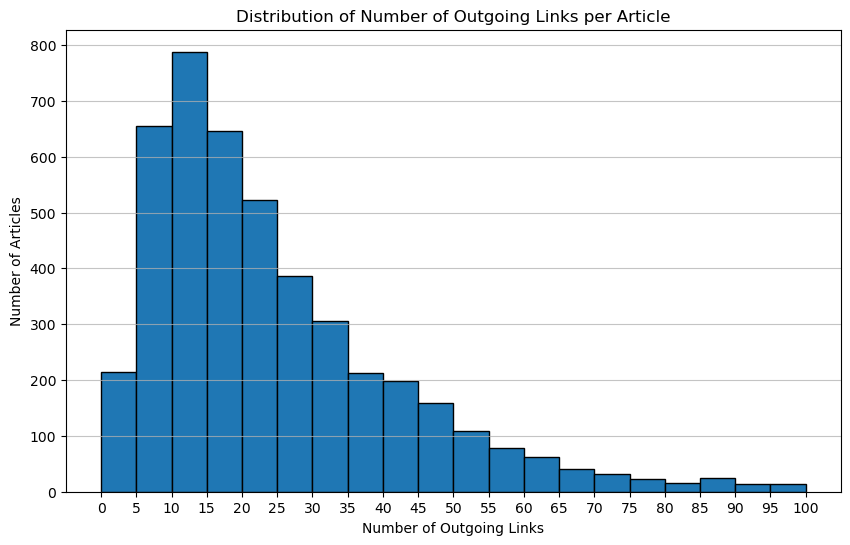

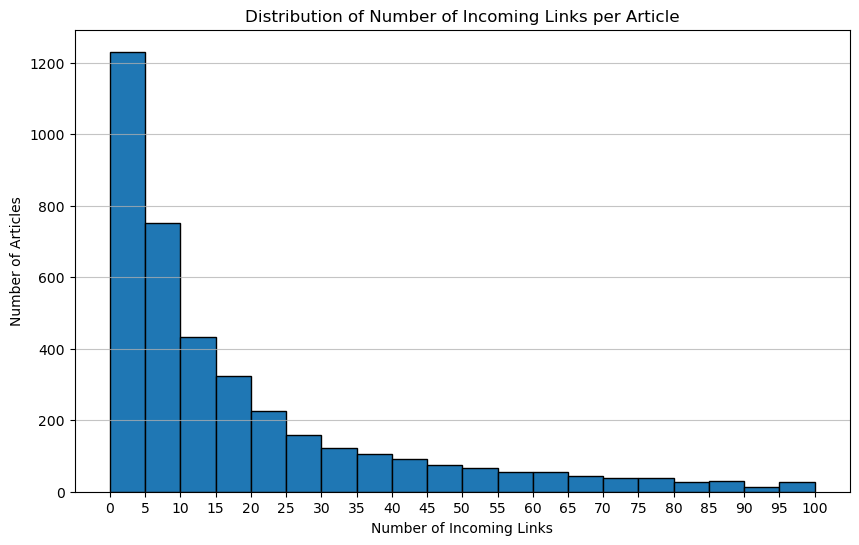

In [9]:
# Creating the outgoing and incoming links counts for each article
outgoing_link_counts = links.groupby('link_source').size()
incoming_link_count = links.groupby('link_target').size()

# Plotting the link distributions 
bins= range(0, 101, 5)
auxiliary.create_link_count_hist(outgoing_link_counts , bins, incoming=False)
auxiliary.create_link_count_hist(incoming_link_count , bins, incoming=True)

Observing the difference in incoming and outgoing links, we notice a clear imbalance, indicating some articles are more central than others in the Wikispeedia network.

In order to further explore how this feature influences player decisions, either consciously or subconsciously, we'll apply the PageRank algorithm. This tool will help us measure the significance of each article in the network, providing insights into their impact on player strategies and the overall game dynamic.

 ### 2) Page Rank Algorithm

We begin by constructing a directed graph of articles using the source and target in the links dataframe. We then use it to run the page rank algorithm.

In [10]:
# Creating the graph
articles_graph = nx.from_pandas_edgelist(links, 'link_source', 'link_target', create_using=nx.DiGraph())

In [11]:
# Running page rank algorithm to detect hubs
page_rank = nx.pagerank(articles_graph, alpha = 0.95)

In [12]:
# Getting the articles with the biggest page rank
top_articles = auxiliary.get_top_articles_by_page_rank(page_rank, top_n=20)

The top 20 articles in terms of page rank are:
United_States  :  0.009935032746117654
France  :  0.007229330714372333
Europe  :  0.0070304734690667175
United_Kingdom  :  0.00678777228452997
English_language  :  0.005449952687638059
Germany  :  0.005431830090461531
World_War_II  :  0.0051700876243443335
Latin  :  0.004939355069146878
India  :  0.0046305652074681665
England  :  0.004594809997467629
Japan  :  0.004294950215222161
Italy  :  0.004210976559873735
Time_zone  :  0.004194672678432141
Spain  :  0.004176952026957267
China  :  0.004051336363203921
Currency  :  0.004004790498849306
Russia  :  0.003989833476264975
Canada  :  0.003623844391861864
Christianity  :  0.0035685560331047794
List_of_countries_by_system_of_government  :  0.003525842378425106


Now that we have our importnace metric for each article, we will use this perspective to analyze the paths we have, we should note however that users have the ability to go back to an article once once visited (back clicks), these jumps are need to be filtered since they don't provide insights into the advancement of the player : 


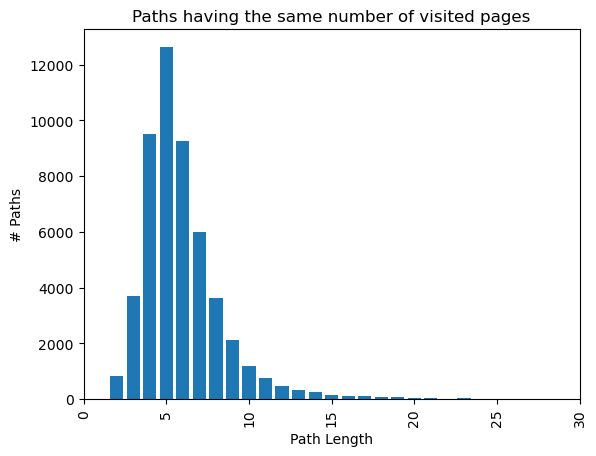

In [13]:
paths_rank_ = []

# Process each path
for i, row in finished_paths.iterrows():
    path_split = auxiliary.parse_and_clean_path(row['path'])
    path_split =  [page_rank.get(page, -1) for page in path_split] 
    path_split = auxiliary.pad_path(path_split)
    paths_rank_.append(path_split)

# Create DataFrame and calculate path lengths
paths_rank_df = pd.DataFrame(paths_rank_)
frequencies_length = auxiliary.calculate_path_lengths(paths_rank_df)


# Plot the path lengths frequencies
auxiliary.plot_path_length_frequencies(frequencies_length)

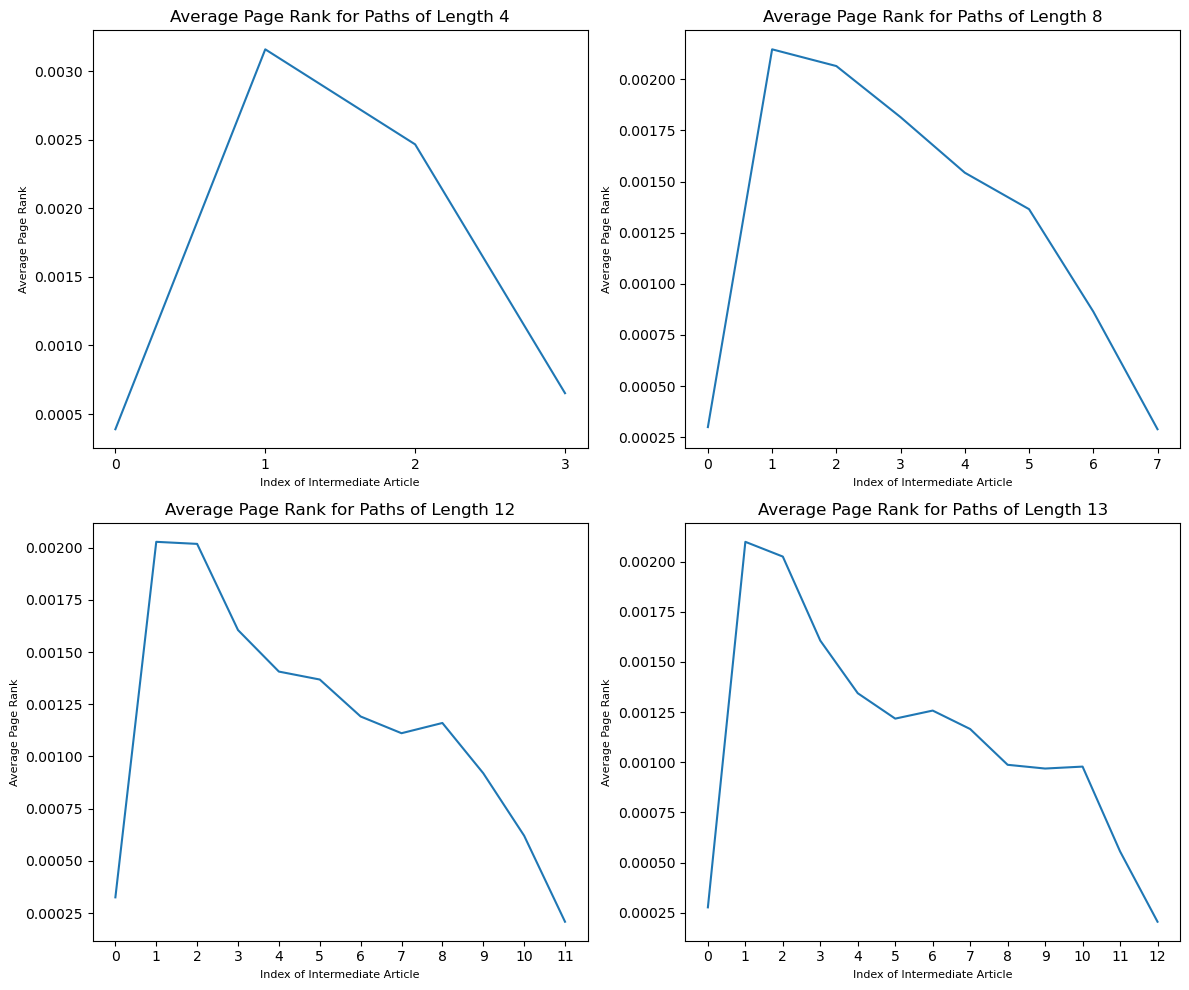

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Assuming paths_rank_df is already defined
path_lengths = [4, 8, 12, 13]
for i, len_ in enumerate(path_lengths):
    auxiliary.plot_avg_page_rank_for_path_length(paths_rank_df, len_, axs[i // 2, i % 2])

fig.tight_layout()
plt.show()

The page rank statistics shown in the graphs suggest the presence of a uniform pattern : each player's path is segmented into two distinct phases - initially, there's an ascent in page rank scores, followed by a descent, with a pivotal, high-ranking page situated at the midpoint of the journey. Notably, this trend is consistent irrespective of the path length, occurring uniformly across all path lengths.

For what follows, we will describe the initial phase, where players progress towards a page with a higher page rank, as the "UpPath." Conversely, the second part of the path characterized by a decline in page rank scores from the peak point, will be referenced as the "DownPath."

### Part 2 - Uncovering User Semantical links for general categories


### 1) Mapping Articles to Categories

To explore the semantic connections between general categories, we will analyze how players transition between these categories during their gameplay. This approach will help us understand the relationships between the general categories of articles, as well as reveal more about the recurring pattern identified earlier, where each player's path is split into a downward path and an upward path, with a highly-ranked page as the pivotal point.

We will start by assigning each article to one of its specific categories, acknowledging that articles may belong to multiple categories. This process will enable us to gain a deeper understanding of the most frequently occurring specific categories within our collection of articles.


In [15]:
categories.head()

,article,category
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.History.British_History.British_Histor...
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.People.Historical_figures
2,%C3%85land,subject.Countries
3,%C3%85land,subject.Geography.European_Geography.European_...
4,%C3%89douard_Manet,subject.People.Artists


129 different categories


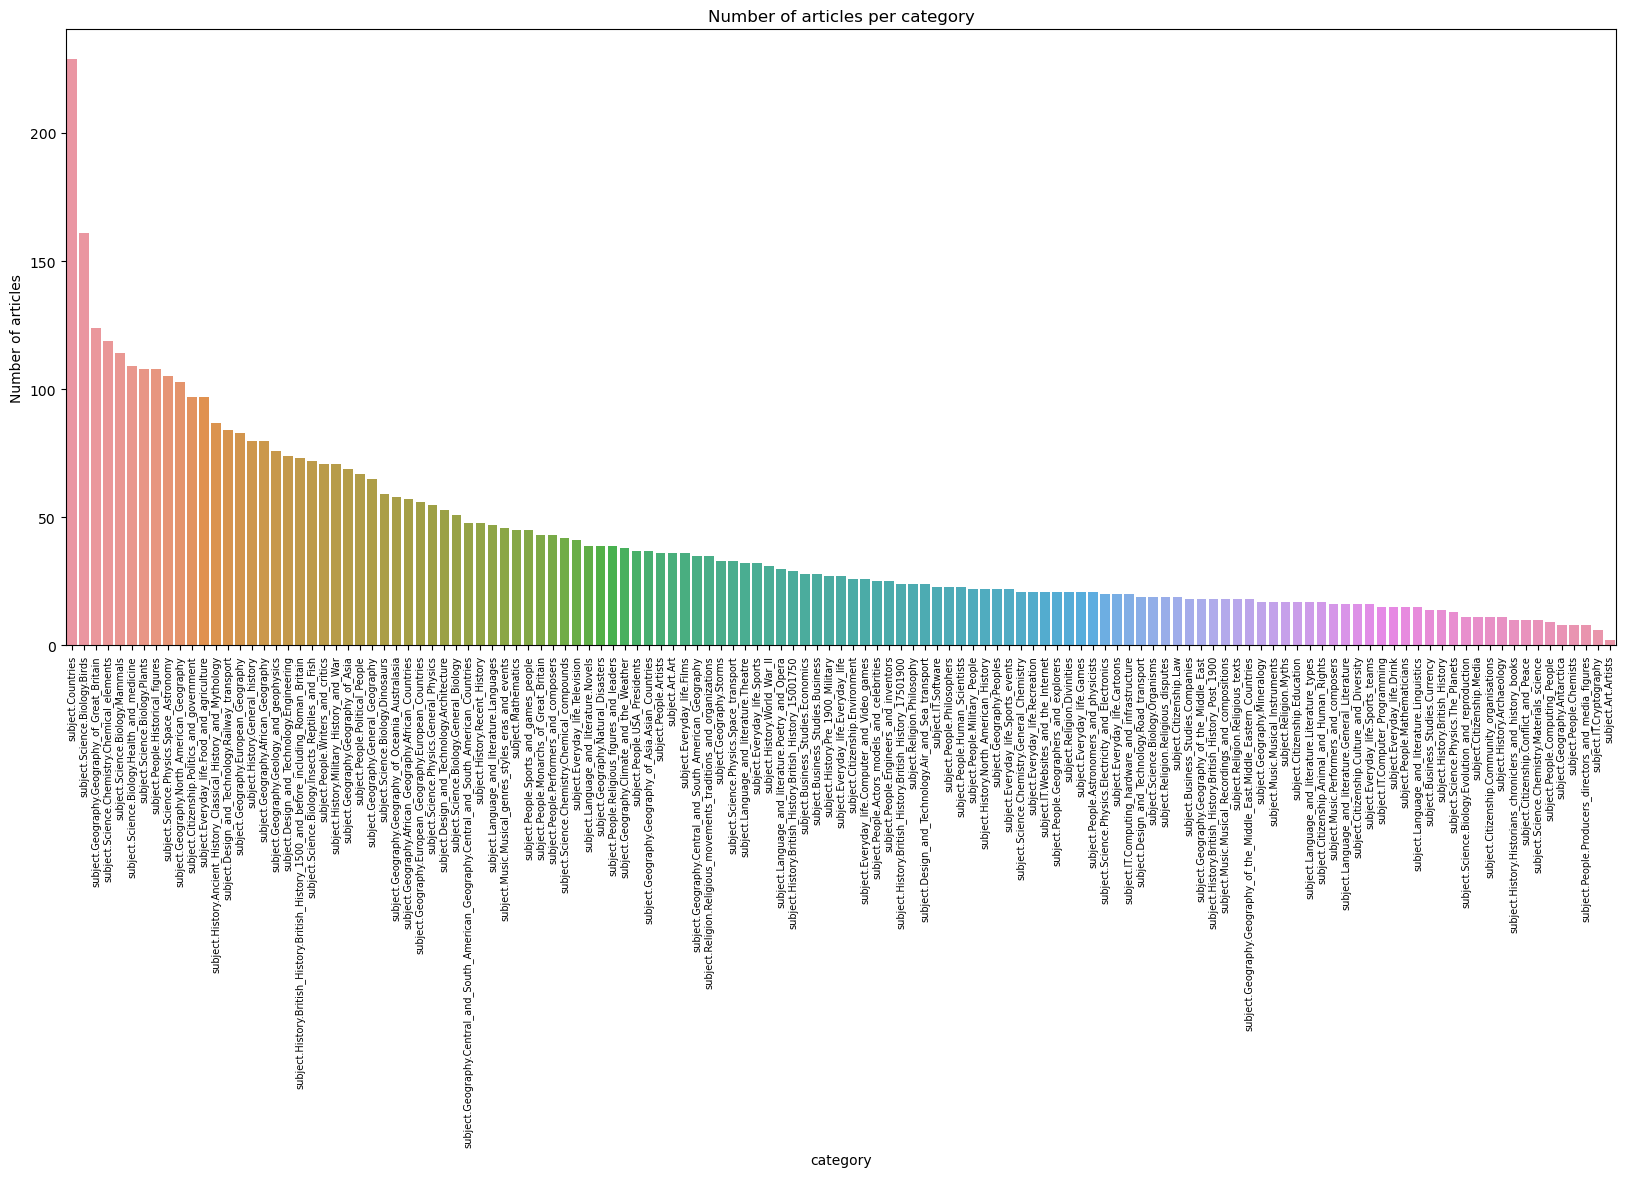

In [16]:
# We plot the frequency of the different categories
auxiliary.plot_categories_frequencies(categories, 'category')

In [63]:
fig.savefig("categories_count_plot.pdf")

During our exploration of the categories dataframe we found that articles can have multiple categories, some more specific than others. We should note two main results that we will exploit in the following analysis :
- The more specific categories that are generally more expressive on the nature of the articles have more periods in their name, this is mainly due to the hierarchy and structure of categories that can be  represented by the following example : "general_category.direct_category.specific_category", therefore the specifity of the category is direcly related to the number of periods in the name.
- Some categories can act as masks for other more interesting categories with the same period count, notably we found that'subject.Countries' in popular articles masks other more interesting categories such as : Geography.Asian/eurpean coutries, we therefore remove this mask during our processing

In [18]:
# Column with the count of periods in the category
categories['period_count'] = categories['category'].apply(auxiliary.count_periods)

# Most specific category for each article
most_specific_category = categories.sort_values(by='period_count', ascending=False).drop_duplicates('article')
specific_categories = most_specific_category.drop(columns=['period_count'])
specific_categories = specific_categories.set_index('article')

specific_categories.head()

,category
article,
%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.History.British_History.British_Histor...
European_Greenfinch,subject.Science.Biology.Birds
Rutherfordium,subject.Science.Chemistry.Chemical_elements
Eurasian_Oystercatcher,subject.Science.Biology.Birds
Eurasian_Jay,subject.Science.Biology.Birds


During Our Exploration of the categories dataframe we found that articles can have multiple categories, some more specific than others, a rec

In [19]:
# Categories of the top articles 
categories_of_top_articles = []
for article in top_articles:
    current_categories = categories[categories['article']==article]['category'].tolist()
    # remove the categry 'subject.Countries' as all pages that have this category 
    filtered_categories = [elem for elem in current_categories if elem!= 'subject.Countries']
    categories_of_top_articles += filtered_categories
    

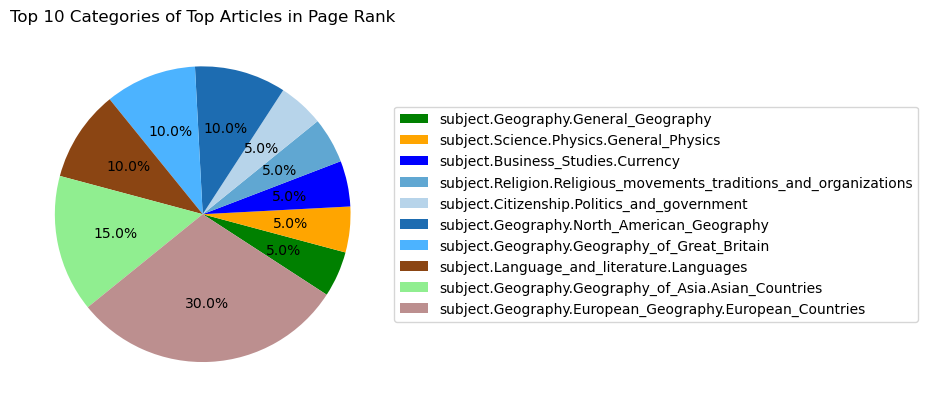

In [20]:

x=np.array(list(Counter(categories_of_top_articles).keys()))
y=np.array(list(Counter(categories_of_top_articles).values()))

# We choose the color palette and plot our pie chatr 
colors=['green', 'orange','blue','#60a7d2','#b7d4ea','#1d6cb1', '#4cb3ff',  'saddlebrown','#90EE90', 'rosybrown']
auxiliary.plot_top_categories_pie_chart(x, y, colors, top_n=10) 

We observe that top ranked articles have categories mainly_ Countries, geography, history, science. This suggest that will have high traffic through those categories. Also we expect the hubs to be mostly part of those categories.

### 2) Constructing Paths of  Categories

We start by extracting the upPath and downPath parts from the finished and unfinished paths

In [21]:
# Processing paths from finished and unfinished datasets relative to the highest-ranked page ('hub').

# Process finished paths in the upward direction (towards the hub) and track pages without a rank.
processed_finished_paths_upPath, pages_with_no_rank_finished_paths_upPath = \
    auxiliary.process_paths_on_rank(finished_paths, page_rank)  

# Process finished paths in the downward direction (away from the hub) and track pages without a rank.
processed_finished_paths_downPath, pages_with_no_rank_finished_paths_downPath = \
    auxiliary.process_paths_on_rank(finished_paths, page_rank, upPath=False)  

# Process unfinished paths in the upward direction (towards the hub) and track pages without a rank.
processed_unfinished_paths_upPath, pages_with_no_rank_unfinished_paths_upPath = \
    auxiliary.process_paths_on_rank(unfinished_paths, page_rank)  

# Process unfinished paths in the downward direction (away from the hub) and track pages without a rank.
processed_unfinished_paths_downPath, pages_with_no_rank_unfinished_paths_downPath = \
    auxiliary.process_paths_on_rank(unfinished_paths, page_rank, upPath=False)  

### 2.1) Analysing Finished Paths Behavior

### + Finished Paths - UpPath



In this part , we will be directed towards the "Up Path" segment of the succesfully finished paths. Specifically, we will utilize all the transitions leading up to the hub ( the article with the maximum page rank score) for each path.Our objective here is to confirm the recurrent pattern that we observed previously, as well as to discover the most recurrent categories of the hubs.

The following code replaces each article in the path by its specific category, it then constructs a heatmap where each entry corresponds to the number of transitions observed in all the UpPaths from the row category to the column category


In [22]:
# transforming the article paths into paths of categories for the UpPath Part of the finished paths 
processed_finished_paths_serie = pd.Series(processed_finished_paths_upPath)
category_finished_paths_upPath = processed_finished_paths_serie.map(lambda path: [specific_categories.loc[article, 'category'] if article in specific_categories.index else 'Unknown_Category' for article in path])
category_finished_paths_upPath.head(1)

0    [subject.History.General_history]
dtype: object

In [23]:
# build category connections for uppath categories 
category_connections_finished_paths_upPath = auxiliary.build_category_connections(category_finished_paths_upPath)
category_connections_finished_paths_upPath

,subject.Business_Studies.Currency,subject.Geography.Central_and_South_American_Geography.Central_and_South_American_Countries,subject.Citizenship.Education,subject.IT.Software,subject.Geography.Geography_of_Great_Britain,subject.Language_and_literature.Poetry_and_Opera,subject.IT.Computing_hardware_and_infrastructure,subject.Science.Physics.The_Planets,subject.Geography.General_Geography,subject.Science.Physics.Space_transport,...,subject.IT.Cryptography,subject.Design_and_Technology.Engineering,subject.Music.Musical_Instruments,subject.Business_Studies.Economics,subject.Everyday_life.Computer_and_Video_games,subject.History.Archaeology,subject.Citizenship.Media,subject.Language_and_literature.Theatre,subject.Music.Musical_Recordings_and_compositions,subject.Science.Biology.Plants
subject.Business_Studies.Currency,52,3,0,0,3,0,0,0,7,0,...,0,0,0,14,0,0,0,0,0,3
subject.Geography.Central_and_South_American_Geography.Central_and_South_American_Countries,4,68,0,0,5,1,0,0,78,0,...,0,3,0,1,0,0,0,0,0,9
subject.Citizenship.Education,0,0,47,0,14,0,1,0,4,0,...,0,9,2,2,0,2,6,0,0,0
subject.IT.Software,0,0,0,63,4,0,19,0,0,0,...,2,0,0,0,2,0,21,0,0,0
subject.Geography.Geography_of_Great_Britain,3,4,16,0,327,1,1,0,105,0,...,0,11,0,2,0,4,3,0,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
subject.History.Archaeology,1,1,0,0,0,0,3,0,5,0,...,0,0,0,0,0,10,0,0,0,0
subject.Citizenship.Media,2,0,1,0,2,0,15,0,4,0,...,0,13,0,0,0,0,26,0,0,0
subject.Language_and_literature.Theatre,0,0,0,0,22,4,0,0,0,0,...,0,0,0,0,0,0,3,22,0,0
subject.Music.Musical_Recordings_and_compositions,0,0,0,0,1,0,0,0,0,0,...,0,0,2,0,0,0,1,0,0,0


['Design_and_Technology', 'Mathematics', 'People', 'Geography', 'Art', 'History', 'Everyday_life', 'Religion', 'Music', 'Citizenship', 'IT', 'Science', 'Language_and_literature', 'Business_Studies']


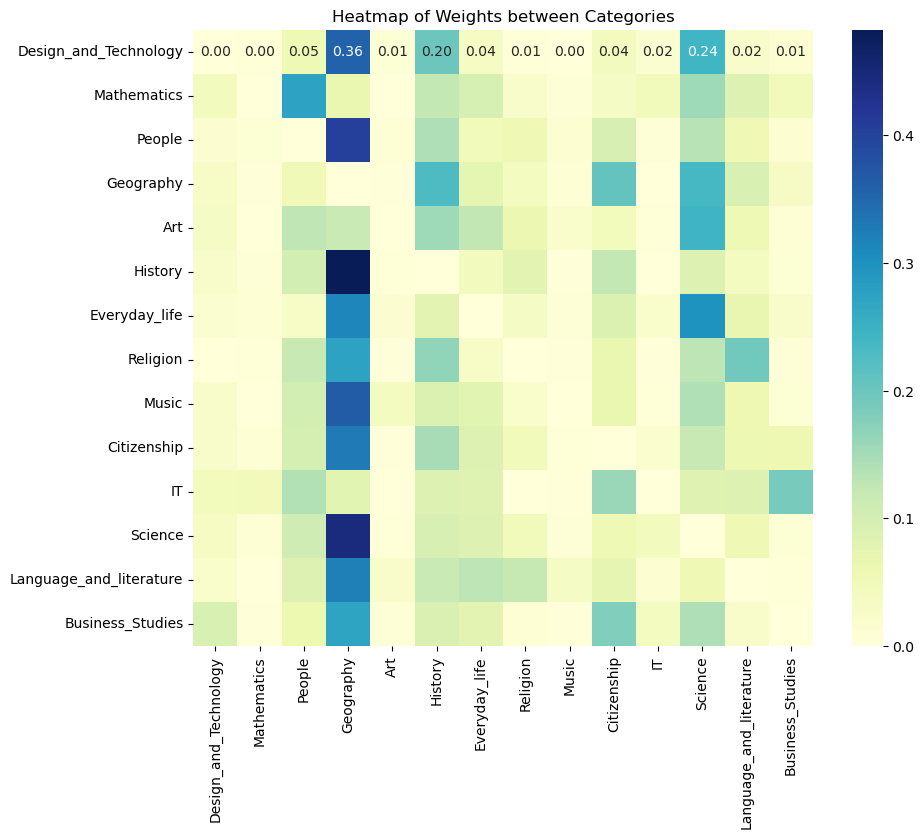

In [24]:
# Visualizing the category connections in a heatmap 
finished_upPath_general_adjacency = auxiliary.heatmap_general_categories(category_connections_finished_paths_upPath)

The heatmaps illustrating transitions in the UpPaths segments reveal that transitions across every category predominantly lead towards Geography categories. This aligns with our hypothesis about hubs belonging to Geography. While Science and History categories also emerge as notable destinations, their prominence is overshadowed by Geography, which dominates the transitions across nearly all categories.

### + Finished Paths - DownPath

In this part , we will  focus on the "Down Paths" segment of the succesfully finished paths. Specifically, we will utilize all the transitions starting from the hub up to the final destination.Since we disovered in the previous sub-section that the first 'Up Path' segment lead to a general category in general(corresponding to the category of the hub), we will be expecting to find that the Down Path(i.e the second part of the transitions) generally involves links from  general category to a specific one.

In [25]:
# transforming the article paths into paths of categories for the downPath Part of the finished paths 
processed_finished_paths_serie_downPath = pd.Series(processed_finished_paths_downPath)
category_finished_paths_downPath = processed_finished_paths_serie_downPath.map(lambda path: [specific_categories.loc[article, 'category'] if article in specific_categories.index else 'Unknown_Category' for article in path])
category_finished_paths_downPath.head(1)

0    [subject.Geography.European_Geography, subject...
dtype: object

In [26]:
# build category connections 
category_connections_finished_paths_downPath = auxiliary.build_category_connections(category_finished_paths_downPath)
category_connections_finished_paths_downPath

,subject.Business_Studies.Currency,subject.Geography.Central_and_South_American_Geography.Central_and_South_American_Countries,subject.Citizenship.Education,subject.IT.Software,subject.Geography.Geography_of_Great_Britain,subject.Language_and_literature.Poetry_and_Opera,subject.IT.Computing_hardware_and_infrastructure,subject.Science.Physics.The_Planets,subject.Geography.General_Geography,subject.Science.Biology.Organisms,...,subject.IT.Cryptography,subject.Design_and_Technology.Engineering,subject.Music.Musical_Instruments,subject.Business_Studies.Economics,subject.Everyday_life.Computer_and_Video_games,subject.History.Archaeology,subject.Citizenship.Media,subject.Language_and_literature.Theatre,subject.Music.Musical_Recordings_and_compositions,subject.Science.Biology.Plants
subject.Business_Studies.Currency,216,17,0,0,1,0,0,0,2,0,...,0,0,0,51,0,0,0,0,0,9
subject.Geography.Central_and_South_American_Geography.Central_and_South_American_Countries,2,266,0,0,2,0,0,0,45,0,...,0,1,2,0,0,0,0,0,0,41
subject.Citizenship.Education,0,0,90,0,28,0,1,0,2,0,...,0,5,1,4,3,1,12,1,0,0
subject.IT.Software,0,0,0,329,0,0,88,0,0,0,...,1,22,0,0,0,0,2,0,0,0
subject.Geography.Geography_of_Great_Britain,22,0,38,0,1316,5,0,1,198,0,...,0,51,0,17,0,1,30,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
subject.History.Archaeology,0,0,0,0,3,0,1,0,44,0,...,0,0,0,0,0,4,0,0,0,1
subject.Citizenship.Media,0,0,7,66,6,0,45,0,0,0,...,0,596,0,0,5,0,161,0,0,0
subject.Language_and_literature.Theatre,0,0,0,0,2,11,0,0,0,0,...,0,0,0,0,0,0,0,37,0,0
subject.Music.Musical_Recordings_and_compositions,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,0


['Design_and_Technology', 'Mathematics', 'People', 'Geography', 'Art', 'History', 'Everyday_life', 'Religion', 'Music', 'Citizenship', 'IT', 'Science', 'Language_and_literature', 'Business_Studies']


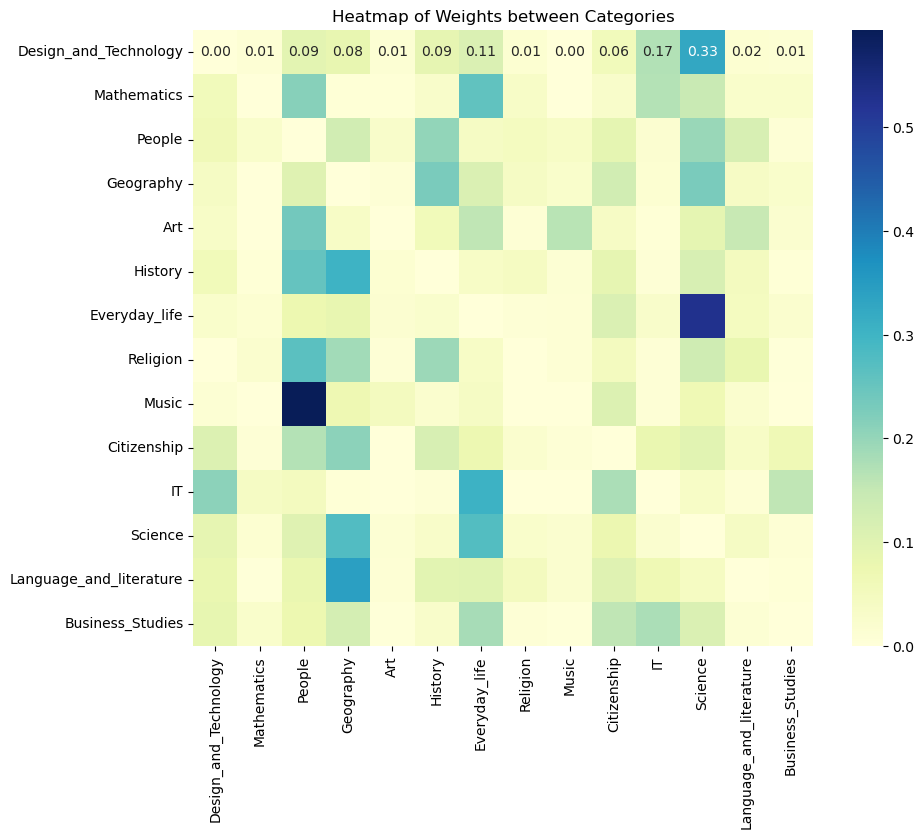

In [27]:
# Visualizing the category connections in a heatmap 
finished_downPath_general_adjacency = auxiliary.heatmap_general_categories(category_connections_finished_paths_downPath)

The heatmaps illustrating the transitions in the DownPath show a different pattern compared to the UpPath heatmap, with a noticeable reduction in the dominance of transitions towards Geography. The DownPath represents the semantic connections between categories that users deliberately navigate to reach their desired destination. This implies that our examination of the semantic relationships between categories should primarily concentrate on the latter part of the paths, as this segment more accurately reflects the user's strategic approach in locating a specific article.


To get a better intuition on the proximity of the general categories, we construct a graph based on the adjacency matrix of the heatmap.
- Biderectionnal edges correspond to a reciprocal connection, where you are as likely to go froma one category to the other 

- Direct Edges from A to B correspond to a one way conenction, the number of edges we have going from  one category to another encodes the strength of the connection going from one to the other, in Milestone 3 we will try to improve the visualization to improve it's expressiveness


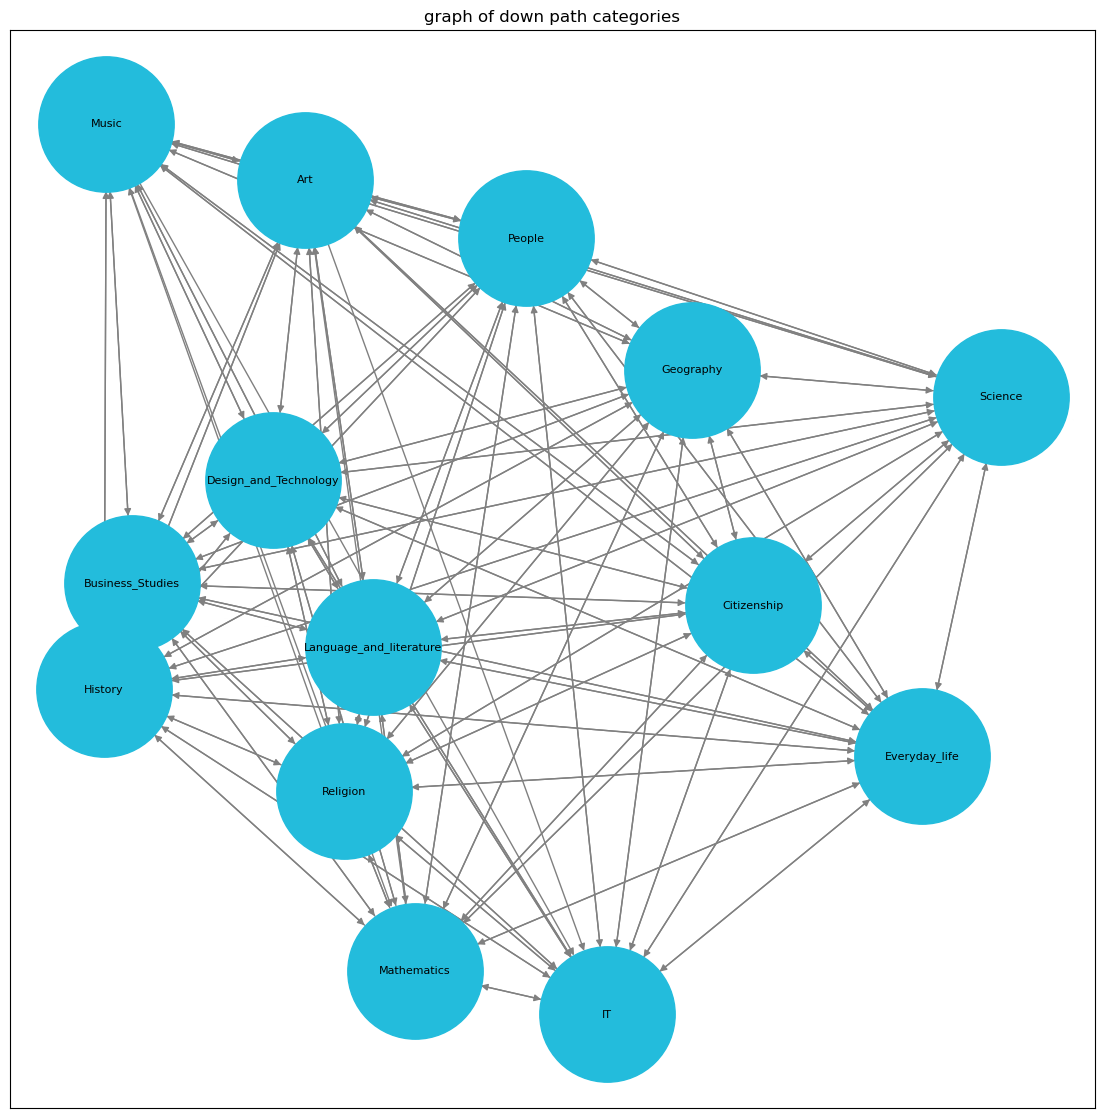

In [28]:
#graph of down path categories in finished paths
G_d= nx.from_pandas_adjacency(finished_downPath_general_adjacency, create_using = nx.DiGraph())

plt.figure(figsize=(14,14))
plt.title('graph of down path categories')
nx.draw_networkx(G_d, edge_color='gray',node_size=9500, font_size=8, node_color='#23bcdc')

### 2.2) Analysing Unfinished Paths Behavior


### + Unfinished Paths - UpPath

In this sub-part, we conduct a similar analysis of the "UpPath" as we did previously for the completed paths, but this time focusing on the unfinished paths. This approach will allow us to  explore the important differences between successful and unsuccessful paths. Are they user logic based, or is there something deaper ? 

In [29]:
# Transforming the article paths into paths of categories for the UpPath Part of the unfinished paths 
processed_unfinished_paths_serie = pd.Series(processed_unfinished_paths_upPath)   #check please
category_unfinished_paths_upPath = processed_unfinished_paths_serie.map(lambda path: [specific_categories.loc[article, 'category'] if article in specific_categories.index else 'Unknown_Category' for article in path])
category_unfinished_paths_upPath.head(3)

0                                                   []
1                                                   []
2    [subject.Geography.African_Geography.African_C...
dtype: object

In [30]:
# Build category connections 
category_connections_unfinished_paths_upPath = auxiliary.build_category_connections(category_unfinished_paths_upPath)
category_connections_unfinished_paths_upPath

,subject.Business_Studies.Currency,subject.Geography.Central_and_South_American_Geography.Central_and_South_American_Countries,subject.Citizenship.Education,subject.IT.Software,subject.Geography.Geography_of_Great_Britain,subject.Language_and_literature.Poetry_and_Opera,subject.IT.Computing_hardware_and_infrastructure,subject.Science.Physics.The_Planets,subject.Geography.General_Geography,subject.Science.Biology.Organisms,...,subject.IT.Cryptography,subject.Design_and_Technology.Engineering,subject.Music.Musical_Instruments,subject.Business_Studies.Economics,subject.Everyday_life.Computer_and_Video_games,subject.History.Archaeology,subject.Citizenship.Media,subject.Language_and_literature.Theatre,subject.Music.Musical_Recordings_and_compositions,subject.Science.Biology.Plants
subject.Business_Studies.Currency,24,1,0,0,1,0,0,0,6,0,...,0,0,0,3,0,0,0,0,0,2
subject.Geography.Central_and_South_American_Geography.Central_and_South_American_Countries,0,25,0,0,0,0,1,0,19,0,...,0,1,0,0,0,0,0,0,0,4
subject.Citizenship.Education,0,0,15,0,4,0,0,0,0,0,...,0,2,0,0,0,0,1,0,0,0
subject.IT.Software,0,0,0,8,0,0,10,0,0,0,...,0,0,0,0,0,0,6,0,0,0
subject.Geography.Geography_of_Great_Britain,4,0,0,0,124,1,0,0,33,0,...,0,5,0,3,0,0,5,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
subject.History.Archaeology,0,0,0,0,1,0,1,0,3,0,...,0,0,0,0,0,6,0,0,0,0
subject.Citizenship.Media,1,0,1,3,1,0,7,0,1,0,...,0,4,0,0,1,0,21,0,0,0
subject.Language_and_literature.Theatre,0,2,0,0,2,4,0,0,0,0,...,0,0,0,0,0,0,0,11,0,0
subject.Music.Musical_Recordings_and_compositions,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


['Design_and_Technology', 'Mathematics', 'People', 'Geography', 'Art', 'History', 'Everyday_life', 'Religion', 'Music', 'Citizenship', 'IT', 'Science', 'Language_and_literature', 'Business_Studies']


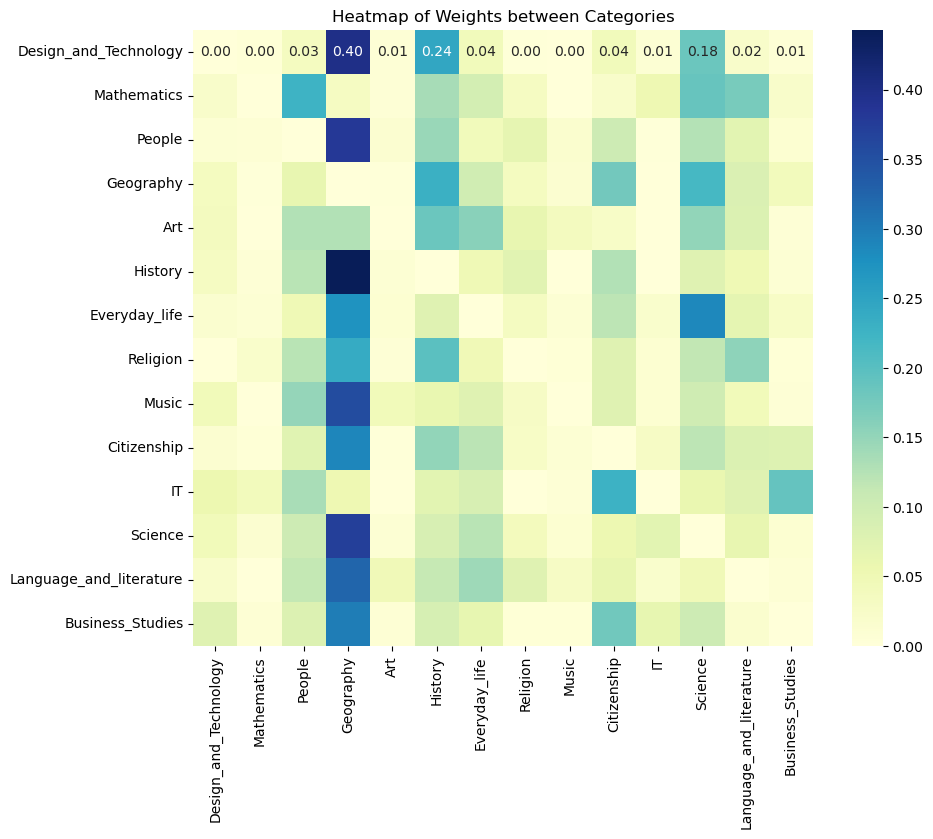

In [31]:
# Constructing the heatMap for the UPPATH of Unfinished paths
tmp = auxiliary.heatmap_general_categories(category_connections_unfinished_paths_upPath)

### +  Unfinished Paths - DownPath

In this subsection , We will conduct the same analysis for the DownPath of the  unfinished paths as we did for the finished paths. Given that we observed the same behavior in both paths for the UpPath segment during the previous subsection, we expect that the finished and unfinished paths both have the same behavior also for the DownPath, which means that we will observe links generally going from a general category to a more specific one.

In [32]:
# Transforming the article paths into paths of categories  
processed_unfinished_paths_serie = pd.Series(processed_unfinished_paths_downPath)
category_unfinished_paths_downPath = processed_unfinished_paths_serie.map(lambda path: [specific_categories.loc[article, 'category'] if article in specific_categories.index else 'Unknown_Category' for article in path])
category_unfinished_paths_downPath.head()

0                        [subject.Everyday_life.Films]
1                  [subject.People.Historical_figures]
2    [subject.Citizenship.Politics_and_government, ...
3    [subject.Geography.Central_and_South_American_...
4    [subject.Geography.Central_and_South_American_...
dtype: object

In [33]:
#Build category connections
category_connections_unfinished_paths_downPath = auxiliary.build_category_connections(category_unfinished_paths_downPath)
category_connections_unfinished_paths_downPath

,subject.Business_Studies.Currency,subject.Geography.Central_and_South_American_Geography.Central_and_South_American_Countries,subject.Citizenship.Education,subject.IT.Software,subject.Geography.Geography_of_Great_Britain,subject.Language_and_literature.Poetry_and_Opera,subject.IT.Computing_hardware_and_infrastructure,subject.Science.Physics.The_Planets,subject.Geography.General_Geography,subject.Science.Physics.Space_transport,...,subject.IT.Cryptography,subject.Design_and_Technology.Engineering,subject.Music.Musical_Instruments,subject.Business_Studies.Economics,subject.Everyday_life.Computer_and_Video_games,subject.History.Archaeology,subject.Citizenship.Media,subject.Language_and_literature.Theatre,subject.Music.Musical_Recordings_and_compositions,subject.Science.Biology.Plants
subject.Business_Studies.Currency,65,1,0,0,0,0,0,0,3,0,...,0,0,0,18,0,0,0,0,0,2
subject.Geography.Central_and_South_American_Geography.Central_and_South_American_Countries,0,79,0,0,1,0,0,0,38,0,...,0,0,0,0,0,0,0,0,0,9
subject.Citizenship.Education,0,0,32,0,16,0,8,0,1,0,...,0,1,0,0,0,0,4,0,0,0
subject.IT.Software,0,0,0,16,0,0,20,0,0,0,...,0,1,0,0,1,0,4,0,0,0
subject.Geography.Geography_of_Great_Britain,1,0,9,0,304,2,0,0,56,1,...,0,6,0,6,0,0,21,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
subject.History.Archaeology,0,0,1,0,0,0,0,0,5,0,...,0,0,0,0,0,2,0,0,0,1
subject.Citizenship.Media,1,1,8,11,1,0,25,0,0,0,...,0,11,0,0,6,0,76,0,0,0
subject.Language_and_literature.Theatre,0,0,0,0,2,2,0,0,0,0,...,0,0,0,0,0,0,0,13,0,0
subject.Music.Musical_Recordings_and_compositions,0,0,0,0,1,0,2,0,0,0,...,0,0,0,0,0,0,0,0,1,0


['Design_and_Technology', 'Mathematics', 'People', 'Geography', 'Art', 'History', 'Everyday_life', 'Religion', 'Music', 'Citizenship', 'IT', 'Science', 'Language_and_literature', 'Business_Studies']


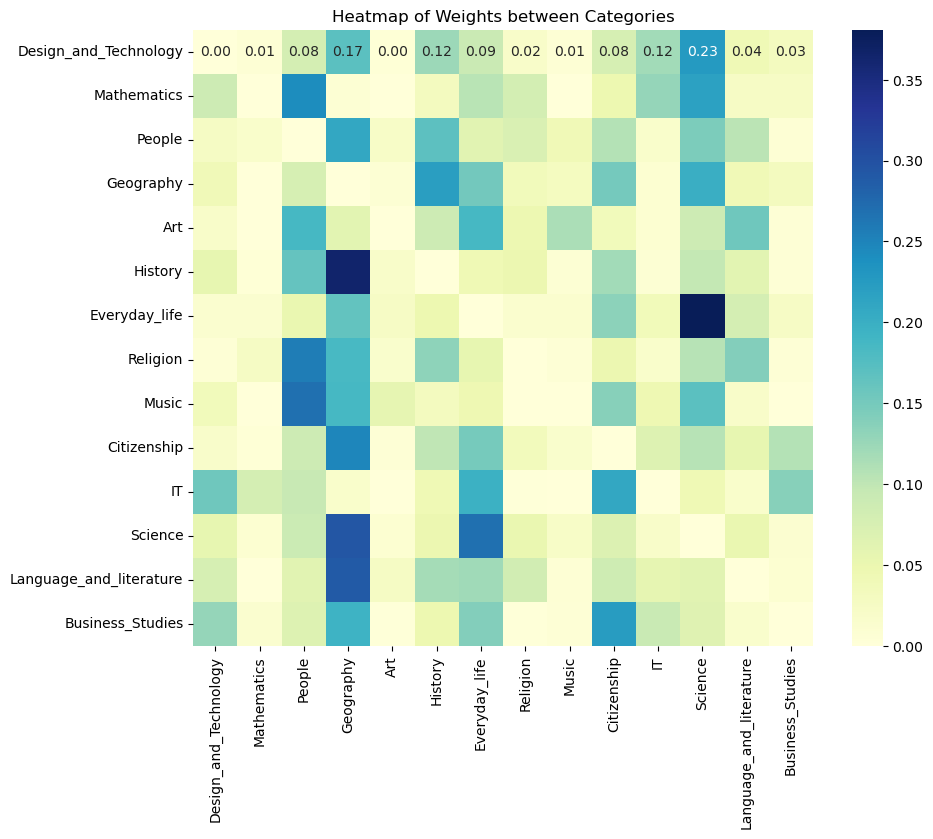

In [34]:
# Constructing the heatMap for the DownPath of Unfinished paths
t2 = auxiliary.heatmap_general_categories(category_connections_unfinished_paths_downPath)

#### Analysis Result : 

Similarly to the finished paths, the downPaths of the unfinished paths shows a decrease in the dominance of transitions towards Geography. The transitions illustrated in the heatmap indicates logical transitions made by the players. The key distinction here is that, unlike in successful paths, the player in this scenario did not manage to reach their final intended destination.

The consistent recurrence of this pattern and the comparable transition behaviors in both finished and unfinished paths imply that the initial starting point of a path does not significantly influence whether the player will successfully reach their intended destination. If cognitive patterns are the same between the two, We  need to dig more into the making of a successful path. 

In the following section, we will focus on identifying the key factors that play a crucial role in determining a player's success in the game.


### Part 3 - Difficulty Analysis

### 1) In-Degree Analysis

In the previous part, we observed that both finished and unfinshed paths have exactly the same pattern :

- The first segment (UpPath) of the path generaly escapes from specific categories to more general ones, up until a hub
- The second segment(DownPath) links have tendency to go from general categories to more specific ones 

This suggests that the difference between finished and unfinshed paths is not related to the starting point, since we always reach a hub starting from any article. the main difference lies in the final destination article, in this section we will try to analyse differences between the destinations of both finished and unfinished paths by comparing the distribution of their in-degrees.

In [35]:
G = articles_graph

# We recover all the in-degrees of the destinations of the unfinished paths
unfinished_paths_in_degrees = unfinished_paths["target"].apply(lambda t: G.in_degree(t)).fillna(0).apply(lambda t : t if isinstance(t, (int)) else 0) + 1 

# We recover all the in-degrees of the destinations of the finished paths
finished_paths_in_degrees = finished_paths["path"].apply(lambda t : G.in_degree(t.split(";")[-1])).apply(lambda t : t if isinstance(t, (int)) else 0) +1    

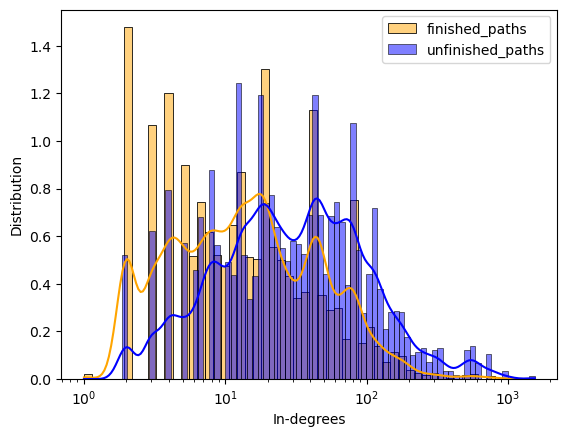

In [36]:
 auxiliary.plot_degree_distribution(unfinished_paths_in_degrees, finished_paths_in_degrees)

In this histogram, it is clear that the destinations of unfinished paths are more likely to have lower in-degrees, indicating greater difficulty in reaching those destinations. Also, we can see that starting from an in-degree of 20 degrees, the destinations of finished paths have a higher probability. This observation aligns with intuition, as higher in-degrees suggest increased popularity of an article, making it more accessible and easier to reach. In Milestone 3 we will further analyse the statistical significance of the difference between the two distributions to improve the soundness of our analysis 

### 1) Page Rank based Prediction model

We observed in the previous parts that logical behavior of players is the same for the finished and unfinished paths. We also observed that the indegree of the targets changes between finished and unfinished paths. We will analyze what influences the success or failure. We considered the following features:

-    #### target_rank  : the page rank of the target page
-    #### starting_rank  the page rank of the starting page
-    #### hub_rank: the page rank of the hub
-    #### indegrees: number of ingoing edges
-    #### num_of_games: number of played games


In [37]:
# We extract from the data useful features for our predictive model

# The number of games played by a player
player_game_count = auxiliary.compute_games_played(finished_paths, unfinished_paths)
p1, p2 = auxiliary.user_games_played(finished_paths, unfinished_paths, player_game_count)

In [38]:
# Extracting the source and targets of finished and unfinished paths 
finished_targets, finished_starting, unfinished_targets, unfinished_starting = \
    auxiliary.get_targets_and_starting_points(finished_paths, unfinished_paths)

# Computing the page rank of source and targets of finished paths 
finished_targets_rank, finished_starting_rank = \
    auxiliary.associate_targets_and_starting_points_with_ranks(finished_targets, finished_starting, page_rank)

# Computing the page rank of source and targets of unfinished paths 
unfinished_targets_rank, unfinished_starting_rank = \
    auxiliary.associate_targets_and_starting_points_with_ranks(unfinished_targets, unfinished_starting, page_rank)

In [39]:
l_finished, l_unfinished = auxiliary.get_hub_ranks(processed_finished_paths_downPath, processed_unfinished_paths_downPath, page_rank)

# Labeling the targets
finished_data = pd.DataFrame({'target_rank': finished_targets_rank, 'label': 1, 'starting_rank ': finished_starting_rank , 'hub_rank ': l_finished })
unfinished_data = pd.DataFrame({'target_rank': unfinished_targets_rank, 'label': 0, 'starting_rank ': unfinished_starting_rank, 'hub_rank ': l_unfinished  })

# Combining the data 
combined_data = pd.concat([finished_data, unfinished_data])

In [40]:
# Extracting the label column
y = combined_data['label']
X = combined_data.drop(columns=["label"])  

#we recover all the in-degrees of the destinations of the un.finished paths
X = auxiliary.calculate_and_update_indegrees(X, finished_paths, unfinished_paths, articles_graph)

#standardize
X = auxiliary.standardize_data(X, p1, p2)

#split the data into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train.head()

,target_rank,starting_rank,hub_rank,indegrees,num_of_games
371,-0.443886,-0.313330,0.117046,-0.362368,61
33856,-0.522977,-0.485599,1.213039,-0.492798,6
6636,-0.213051,0.247690,-0.347991,-0.134116,172
37870,-0.552582,-0.490558,0.235113,-0.503667,21
15878,0.515319,0.705661,0.288831,0.333257,60


In [41]:
# Train a logistic regression model
model = auxiliary.train_logistic_regression(X_train, y_train)

# Construct a dataframe that contains the coefficients of the features
features_coef = auxiliary.feature_coefficients(model, X_train)

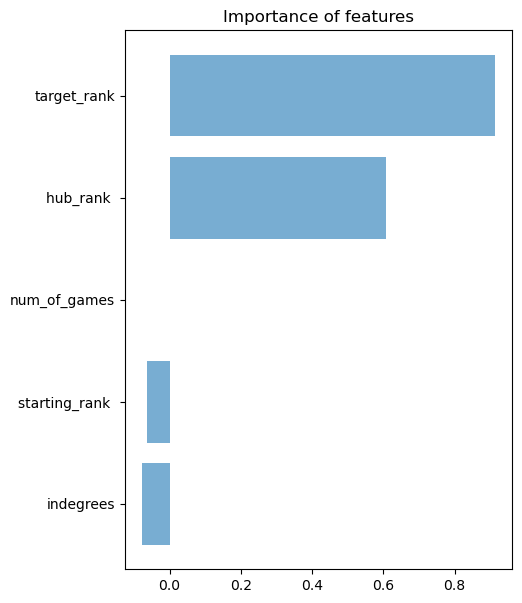

Accuracy: 0.7230971128608924
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.27      0.39      2493
           1       0.73      0.95      0.82      5127

    accuracy                           0.72      7620
   macro avg       0.71      0.61      0.60      7620
weighted avg       0.72      0.72      0.68      7620



In [42]:
# plot horizontal hist of the importance of the feature coefficients
auxiliary.plot_feature_coefficients(features_coef)

# Evaluate the model
accuracy, report = auxiliary.evaluate_model(model, X_test, y_test)
print("Accuracy:", accuracy)
print("Classification Report:\n", report)

The analysis reveals that player experience does not significantly impact their performance in the game. Instead, the PageRank scores of the hub and target articles emerge as the most influential factors. Interestingly, the PageRank of the starting article appears to have little effect on the game's outcome.

Our analysis has primarily concentrated on examining the model through the scope of its coefficients to assess the relative importance of each feature. In Milestone 3, our focus will shift towards evaluating various models and incorporating an expanded set of features to enhance the predictive capability of our model.

### Part 4 : Deeper dive into Cognitive Mappings 

In this final section, we will take a step back from the game difficulty and focus on analyzing further the cognitive connections between closely related categories. We will provide analysis for science-related categories, however er note that this same procedure can be further generalized to other fields (we will elaborate those links in the third Milestone).

Our aim is to identify semantic connections among these categories, grouping them into clusters of similar ones. This approach is guided by human intuition and reasoning. Since we've found that only the DownPath from the successfully completed paths is effective for semantic analysis, we will only focus on this part of the paths to construct a similarity matrix for the science categories.

In [43]:
# Copy of the finished_paths
finished_paths_tmp = finished_paths.copy()

# Keeping only the finished_paths with destination belonging to the science category, we also added a specific_category and general_category columns
finished_paths_tmp["specific_categ"] = [specific_categories.loc[t.split(";")[-1], 'category'] if t.split(";")[-1] in specific_categories.index else 'Unknown_Category'  for t in finished_paths_tmp["path"]]
finished_paths_tmp["general_categ"] = [ t.split(".")[1] if t!= "Unknown_Category" else "Unknown_Category" for t in   finished_paths_tmp["specific_categ"] ]
finished_paths_tmp = finished_paths_tmp[finished_paths_tmp["general_categ"] == "Science"]


In [44]:
# Computing the similarity matrix between the specific categories
data_frame_science= auxiliary.compute_similarity_matrix(finished_paths_tmp, categories)

In [45]:
# Create a graph from the DataFrame
G = nx.from_pandas_adjacency(data_frame_science, create_using=nx.DiGraph())

# Rename nodes to remove the 'subject.Science' prefix
G = nx.relabel_nodes(G, lambda x: x.replace('subject.Science', ''))

# Find the top 3 most related topics for each category
top_3_related = {}
for node in G.nodes():
    neighbors = G[node]
    top_3_related[node] = sorted(neighbors, key=lambda x: neighbors[x]['weight'], reverse=True)[:3]

# Create a new directed graph with only the top 3 related edges
G_top_3 = nx.DiGraph()
for node, related_nodes in top_3_related.items():
    for related_node in related_nodes:
        if (node, related_node) in G.edges():
            weight = G.get_edge_data(node, related_node)['weight']
            G_top_3.add_edge(node, related_node, weight=weight)

# Improve node positioning 
pos = nx.kamada_kawai_layout(G_top_3)
adjusted_pos = auxiliary.adjust_label_pos(pos)

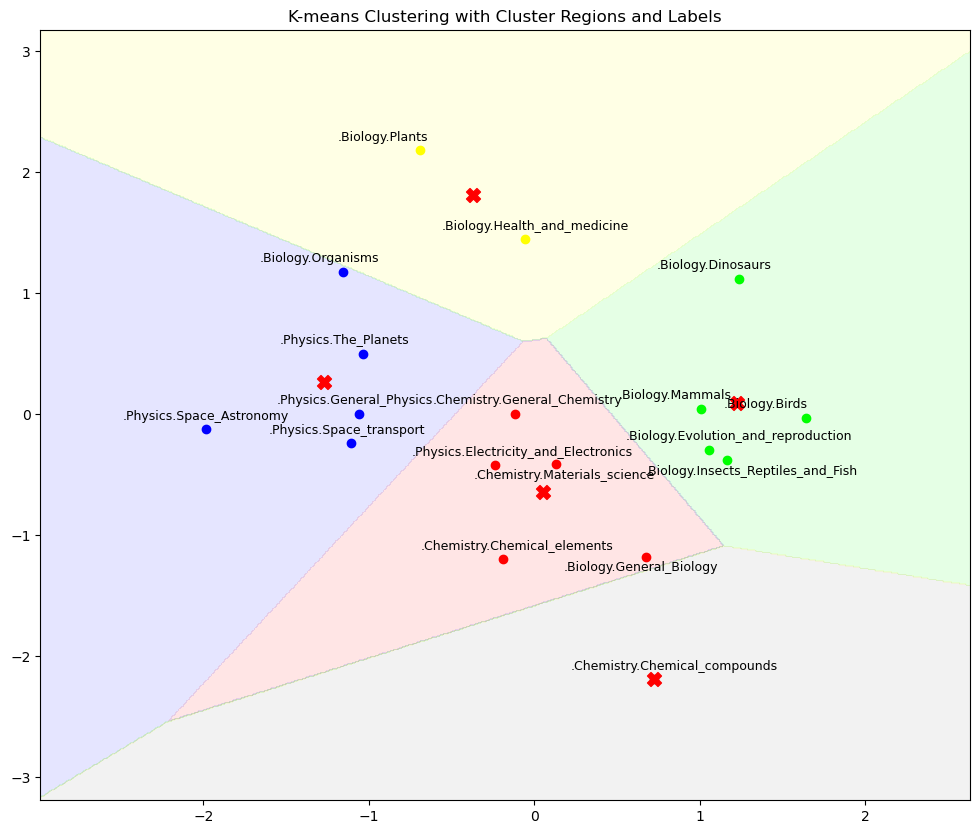

In [46]:
# Plotting the clustering of specific catgories 
# the crosses in the plot represent the means, the colored dots are the categories
df_dict = pd.DataFrame.from_dict(adjusted_pos, orient='index')
auxiliary.kmeans_clustering_and_plot(df_dict)

The graph illustrates that the pathways taken by players in the downpath of successfully completed paths demonstrate a coherent and semantic grouping of science categories. For instance, there is a distinct Biology cluster grouping categories like Insects, Reptiles, Birds, and Evolution and Reproduction. On the left side of the graph, a Physics cluster is evident, containing categories such as Space Astronomy, The Planets, and Space Transport. This clustering reflects a logical organization of scientific disciplines as navigated by the players.